/home/rgautham20/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


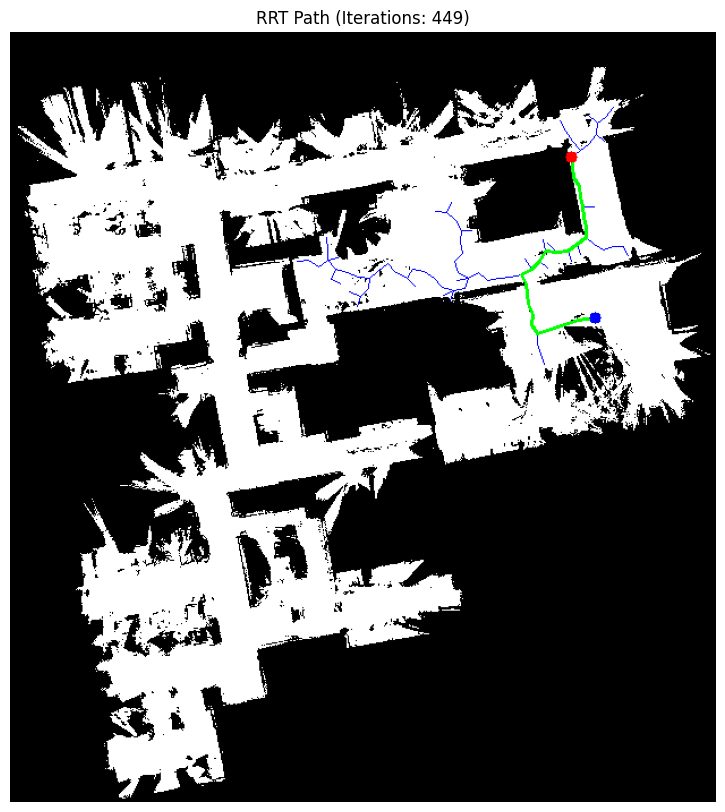

Results for /home/rgautham20/MR/final_project/data1.png:
  Iterations: 449
  Path Length: 252.16
  Path Smoothness: 0.4238
  Time Taken: 0.02 seconds



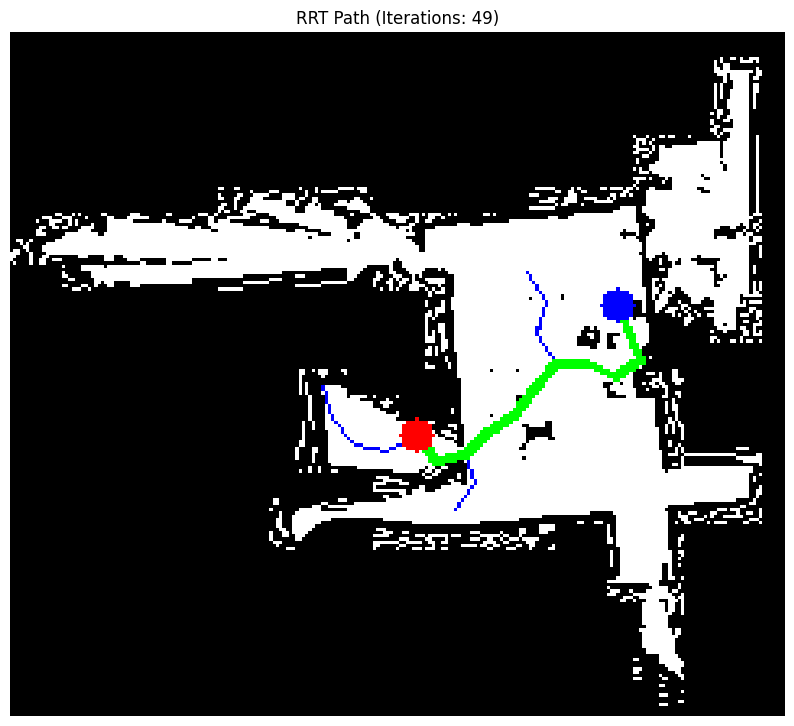

Results for /home/rgautham20/MR/final_project/b_data2.png:
  Iterations: 49
  Path Length: 105.95
  Path Smoothness: 0.4235
  Time Taken: 0.00 seconds



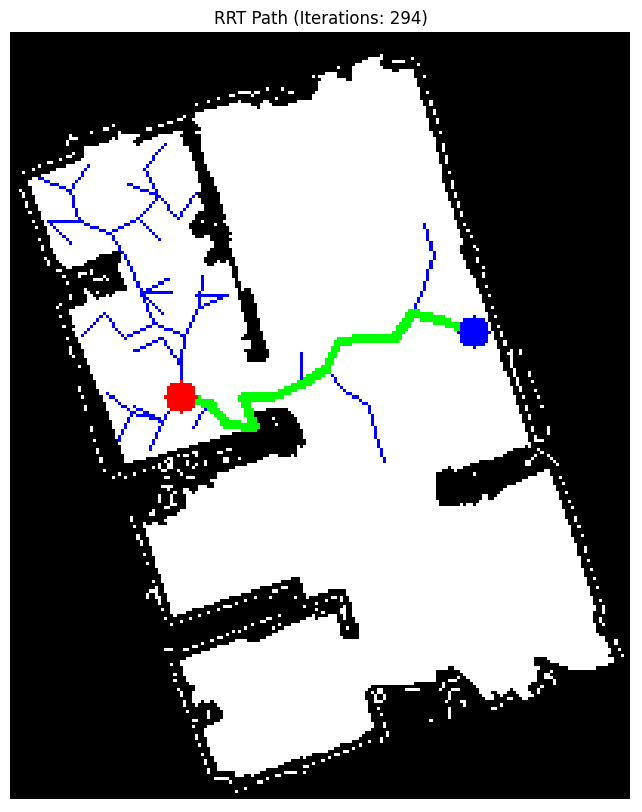

Results for /home/rgautham20/MR/final_project/b_data3.png:
  Iterations: 294
  Path Length: 126.38
  Path Smoothness: 0.6244
  Time Taken: 0.01 seconds



In [1]:
import cv2
import numpy as np
import imageio
import time
import math
import random
import matplotlib.pyplot as plt

class Node:
    def __init__(self, coords, parent=None):
        self.coords = coords
        self.parent = parent

def euclidean_distance(p1, p2):
    return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

def is_collision_free(p1, p2, img):
    line = np.linspace(p1, p2, num=int(euclidean_distance(p1, p2)))
    for point in line:
        x, y = int(point[0]), int(point[1])
        if img[y, x] == 0:  # Black pixel indicates obstacle
            return False
    return True

def get_nearest_node(nodes, random_point):
    return min(nodes, key=lambda node: euclidean_distance(node.coords, random_point))

def generate_random_point(image_shape):
    return random.randint(0, image_shape[1] - 1), random.randint(0, image_shape[0] - 1)

def backtrack_path(goal_node):
    path = []
    current_node = goal_node
    while current_node is not None:
        path.append(current_node.coords)
        current_node = current_node.parent
    return path[::-1]

def rrt(start, goal, img, step_size=10, max_iterations=2500, goal_tolerance=20):
    start_node = Node(start)
    goal_node = Node(goal)
    nodes = [start_node]
    found_path = False

    for iteration in range(max_iterations):
        if random.random() < 0.1:
            random_point = goal
        else:
            random_point = generate_random_point(img.shape)

        nearest_node = get_nearest_node(nodes, random_point)
        direction = np.array(random_point) - np.array(nearest_node.coords)
        length = np.linalg.norm(direction)
        direction = direction / length if length != 0 else direction

        new_coords = (int(nearest_node.coords[0] + direction[0] * step_size),
                      int(nearest_node.coords[1] + direction[1] * step_size))

        if 0 <= new_coords[0] < img.shape[1] and 0 <= new_coords[1] < img.shape[0] and is_collision_free(nearest_node.coords, new_coords, img):
            new_node = Node(new_coords, nearest_node)
            nodes.append(new_node)

            if euclidean_distance(new_node.coords, goal) <= goal_tolerance:
                goal_node.parent = new_node
                found_path = True
                break

    if found_path:
        return backtrack_path(goal_node), iteration + 1, nodes
    else:
        return None, iteration + 1, nodes

def calculate_path_length(path):
    return sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))

def calculate_path_smoothness(path):
    angles = []
    for i in range(1, len(path) - 1):
        v1 = np.array(path[i]) - np.array(path[i - 1])
        v2 = np.array(path[i + 1]) - np.array(path[i])
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle = np.arccos(cos_angle)
        angles.append(angle)
    return np.std(angles) if angles else 0.0

def process_image(image_path, start_coords, goal_coords, output_gif):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    images_for_gif = []
    start_time = time.time()

    path, iterations, nodes = rrt(start_coords, goal_coords, img)
    end_time = time.time()

    # Draw the tree and path
    for node in nodes:
        if node.parent:
            cv2.line(img_color, node.coords, node.parent.coords, (255, 0, 0), 1)
    
    if path:
        for i in range(1, len(path)):
            cv2.line(img_color, path[i - 1], path[i], (0, 255, 0), 2)
    
    # Mark start and goal nodes
    cv2.circle(img_color, start_coords, 5, (0, 0, 255), -1)
    cv2.circle(img_color, goal_coords, 5, (255, 0, 0), -1)

    # Convert image to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    
    # Save the frame for the GIF
    images_for_gif.append(img_rgb)

    # Save GIF
    imageio.mimsave(output_gif, images_for_gif, duration=0.02)

    # Display the final result using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(f"RRT Path (Iterations: {iterations})")
    plt.axis("off")
    plt.show()

    if path:
        path_length = calculate_path_length(path)
        path_smoothness = calculate_path_smoothness(path)
        time_taken = end_time - start_time

        print(f"Results for {image_path}:")
        print(f"  Iterations: {iterations}")
        print(f"  Path Length: {path_length:.2f}")
        print(f"  Path Smoothness: {path_smoothness:.4f}")
        print(f"  Time Taken: {time_taken:.2f} seconds\n")
    else:
        print(f"Path not found for {image_path} after {iterations} iterations.")

# Inputs with image paths and start/goal coordinates
inputs = [
    {"image_path": "/home/rgautham20/MR/final_project/data1.png", "start": (495, 110), "goal": (516, 252), "output_gif": "/home/rgautham20/MR/final_project/rrt_expansion_1.gif"},
    {"image_path": "/home/rgautham20/MR/final_project/b_data2.png", "start": (125, 124), "goal": (187, 84), "output_gif": "/home/rgautham20/MR/final_project/rrt_expansion_2.gif"},
    {"image_path": "/home/rgautham20/MR/final_project/b_data3.png", "start": (55, 118), "goal": (150, 97), "output_gif": "/home/rgautham20/MR/final_project/rrt_expansion_3.gif"}
]

for input_data in inputs:
    process_image(input_data["image_path"], input_data["start"], input_data["goal"], input_data["output_gif"])
